In [1]:
from layerwise_activations import store_layerwise_activations
from utils import set_up_dir, ReportInterface
import matplotlib.pyplot as plt
import h5py
import caffe
import numpy as np
import lmdb
%matplotlib inline

/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/mnt/antares_raid/home/oliver/adhara/src/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \


In [ ]:
# ACTIVITY
date = '2408'
snap = '390000'
caffemodels =  ['/mnt/antares_raid/home/oliver/Experiments/{}/R/snapshots/_iter_{}.caffemodel'.format(date,snap),
                '/mnt/antares_raid/home/oliver/Experiments/{}/UR/snapshots/_iter_{}.caffemodel'.format(date,snap),
                '/mnt/antares_raid/home/oliver/Experiments/{}/N25NR/snapshots/_iter_{}.caffemodel'.format(date,snap),
                '/mnt/antares_raid/home/oliver/Experiments/{}/N25NUR/snapshots/_iter_{}.caffemodel'.format(date,snap),
                '/mnt/antares_raid/home/oliver/Experiments/{}/N50NR/snapshots/_iter_{}.caffemodel'.format(date,snap),
                '/mnt/antares_raid/home/oliver/Experiments/{}/N50NUR/snapshots/_iter_{}.caffemodel'.format(date,snap)
                ]
phase = caffe.TRAIN
net_prototxt = '/mnt/antares_raid/home/oliver/Experiments/{}/MLP/AER/MLP_net.prototxt'.format(date)
keys=['encode1neuron', 'encode2neuron', 'encode3neuron', 'encode4neuron'] 
model = '/mnt/antares_raid/home/oliver/Experiments/{}/R/snapshots/_iter_{}.caffemodel'.format(date,snap)

lmdb_path = '/mnt/raid/dnn/data_oliver/lmdb/MNIST_TRAIN_60000_rot_lmdb/shuffled/'
keys = ['encode1neuron', 'encode2neuron', 'encode3neuron', 'encode4neuron']
n = 780
dst_fpath= '/mnt/antares_raid/home/oliver/Experiments/{}/R/activations/activity.hdf5'.format(date)

In [ ]:
store_layerwise_activations(net_prototxt, model, phase, keys, n, dst_fpath)

In [ ]:
#ROTATION ANGLES
rot_lmdb_path =  '/mnt/raid/dnn/data_oliver/lmdb/MNIST_TRAIN_60000_rot_ang_lmdb/shuffled/'

lmdb_env = lmdb.open(rot_lmdb_path)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
R = []
im_count = 0
for key, value in lmdb_cursor:
        R.append(value)
Rot = np.asarray([float(r) for r in R])
Rot = Rot - np.min(Rot)
Rot = Rot/np.max(Rot)
    

In [ ]:
# CORRELATIONS
dst_fpath='/mnt/antares_raid/home/oliver/Experiments/R/activations/activity.hdf5'
keys = ['encode1neuron', 'encode2neuron', 'encode3neuron', 'encode4neuron']

import scipy 
C = {k:{} for k in keys}
with h5py.File(dst_fpath, "r") as f: #f[k]: n*batchsize x 784
    for k in f:
        print(k)
        for nr, r in enumerate(list(set(Rot))):
            print(r)
            Rot_r = np.copy(Rot)
            Rot_r[Rot_r != r] = 0.
            C[k].update({str(r): np.array([scipy.stats.pearsonr(Rot_r,f[k][:,i] ) for i in range(f[k].shape[1] )] )})


## Activity distributions

In [4]:

date = '2408'
snap = '390000'
dst_fpath= '/mnt/antares_raid/home/oliver/Experiments/{}/R/activations/activity.hdf5'.format(date)
keys = ['encode1neuron', 'encode2neuron', 'encode3neuron', 'encode4neuron']

dst_fpath= '/mnt/antares_raid/home/oliver/Experiments/{}/R/activations/activity.hdf5'.format(date)

S = ReportInterface()
#S.__save_dict_to_hdf5__(C, dst_fpath)

CL = S.__load_dict_from_hdf5__(dst_fpath)


encode1neuron


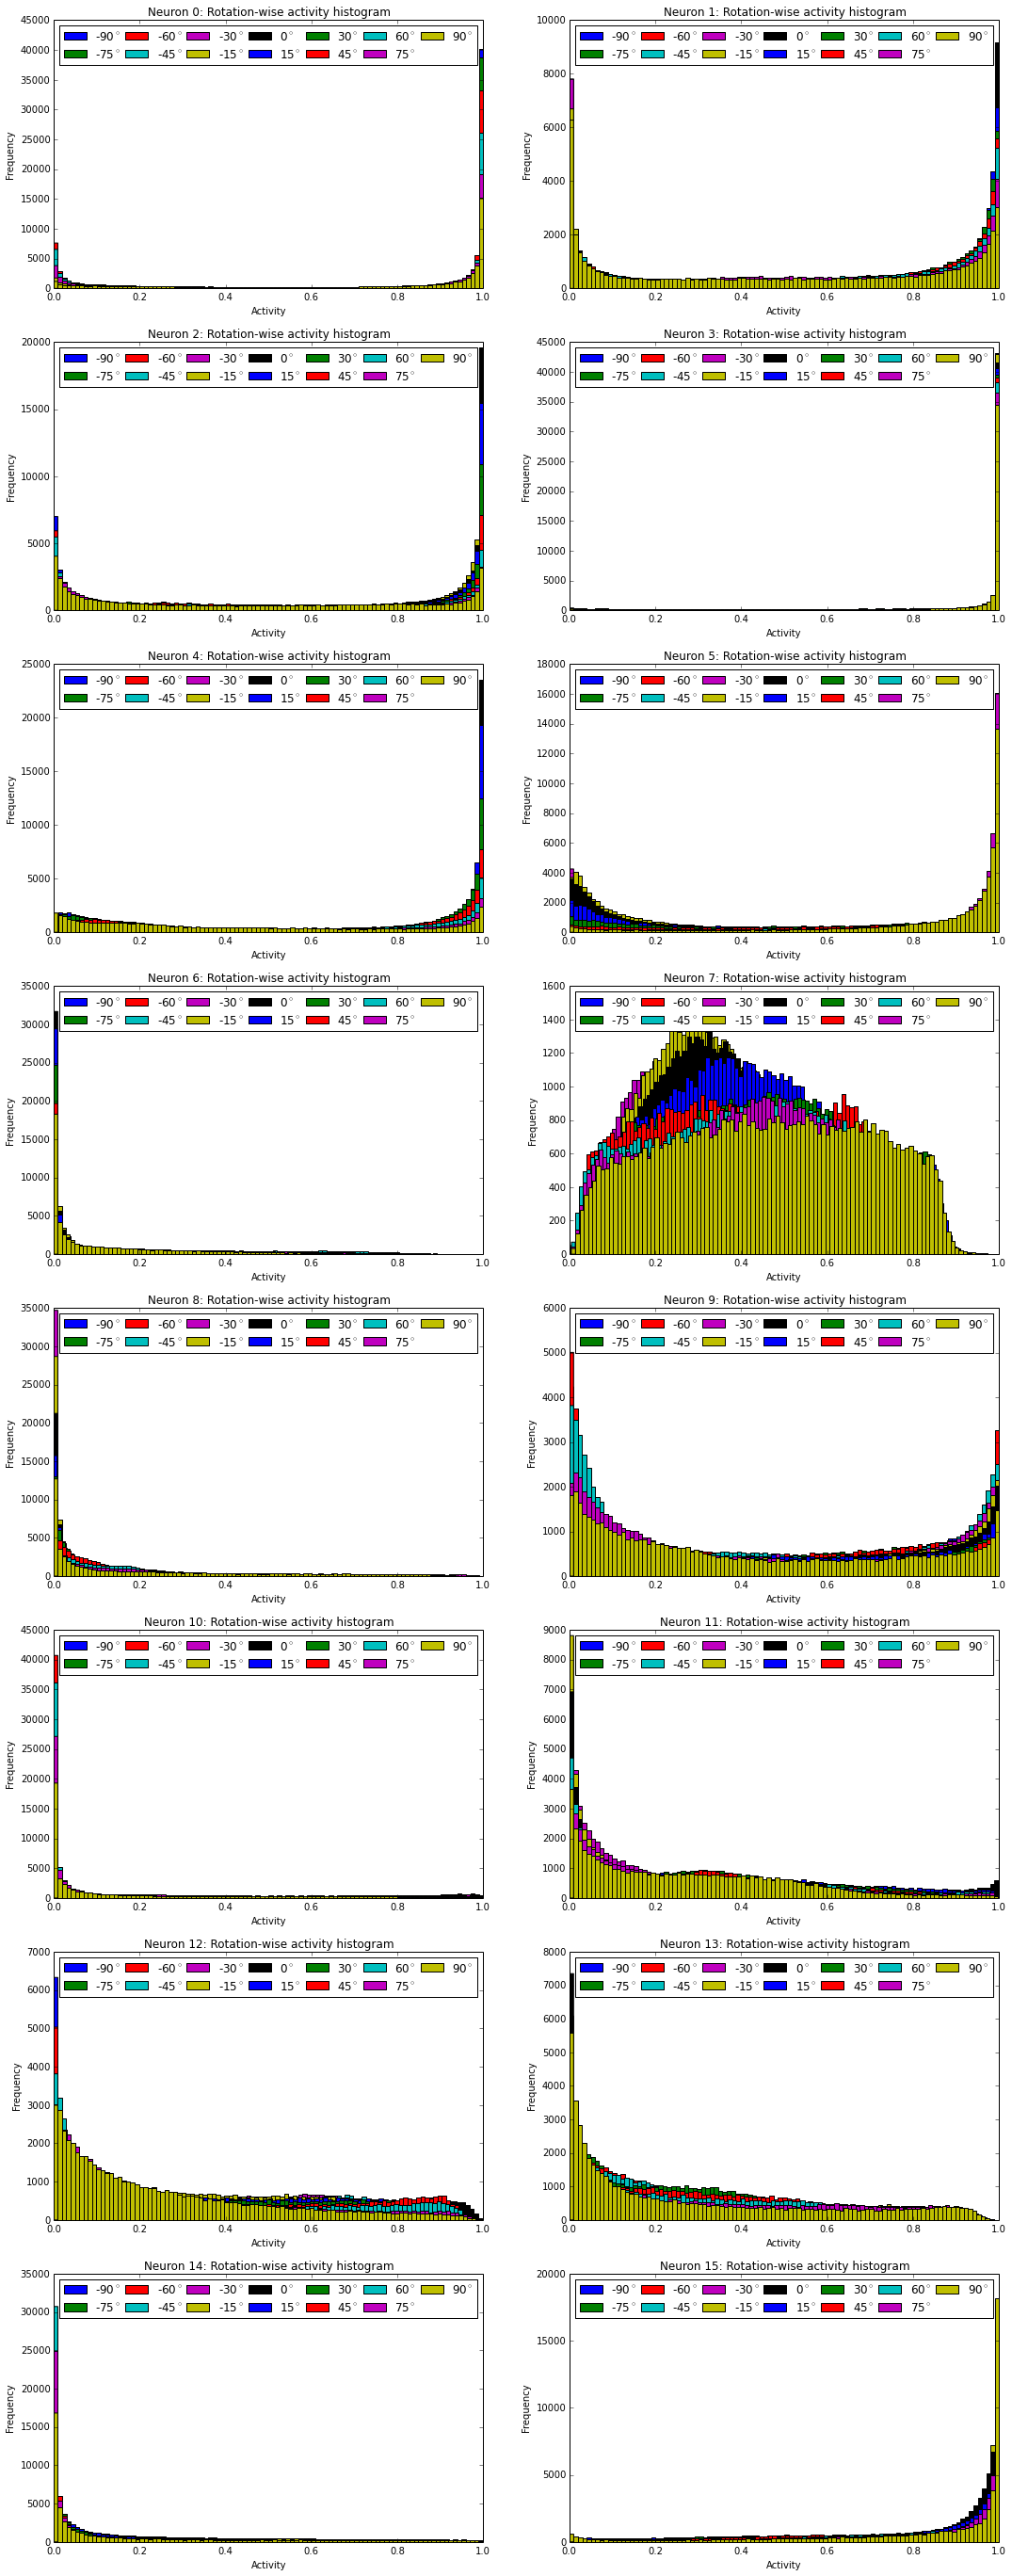

encode2neuron


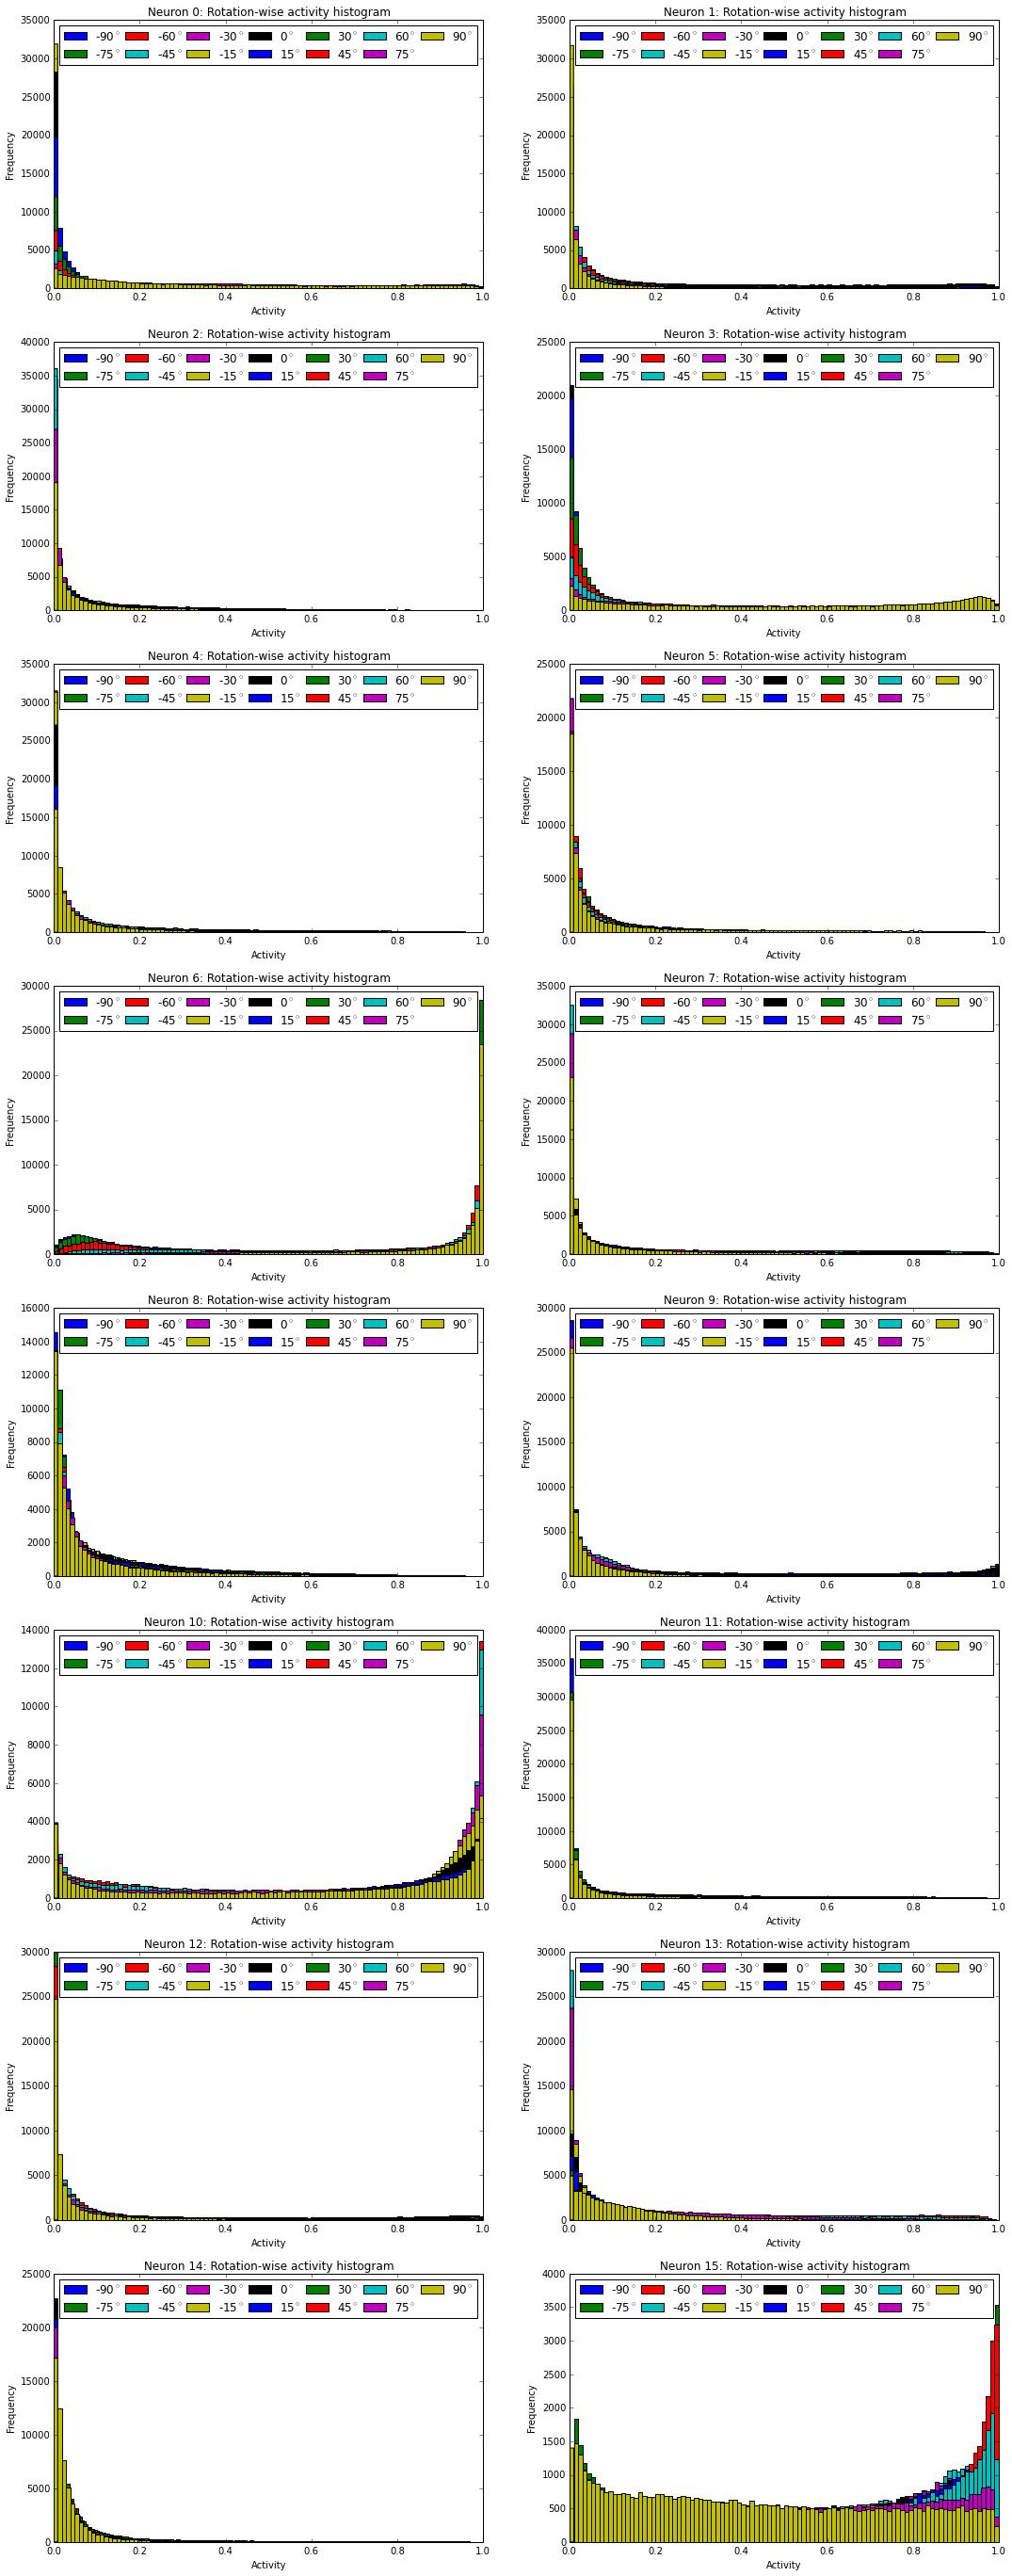

encode3neuron


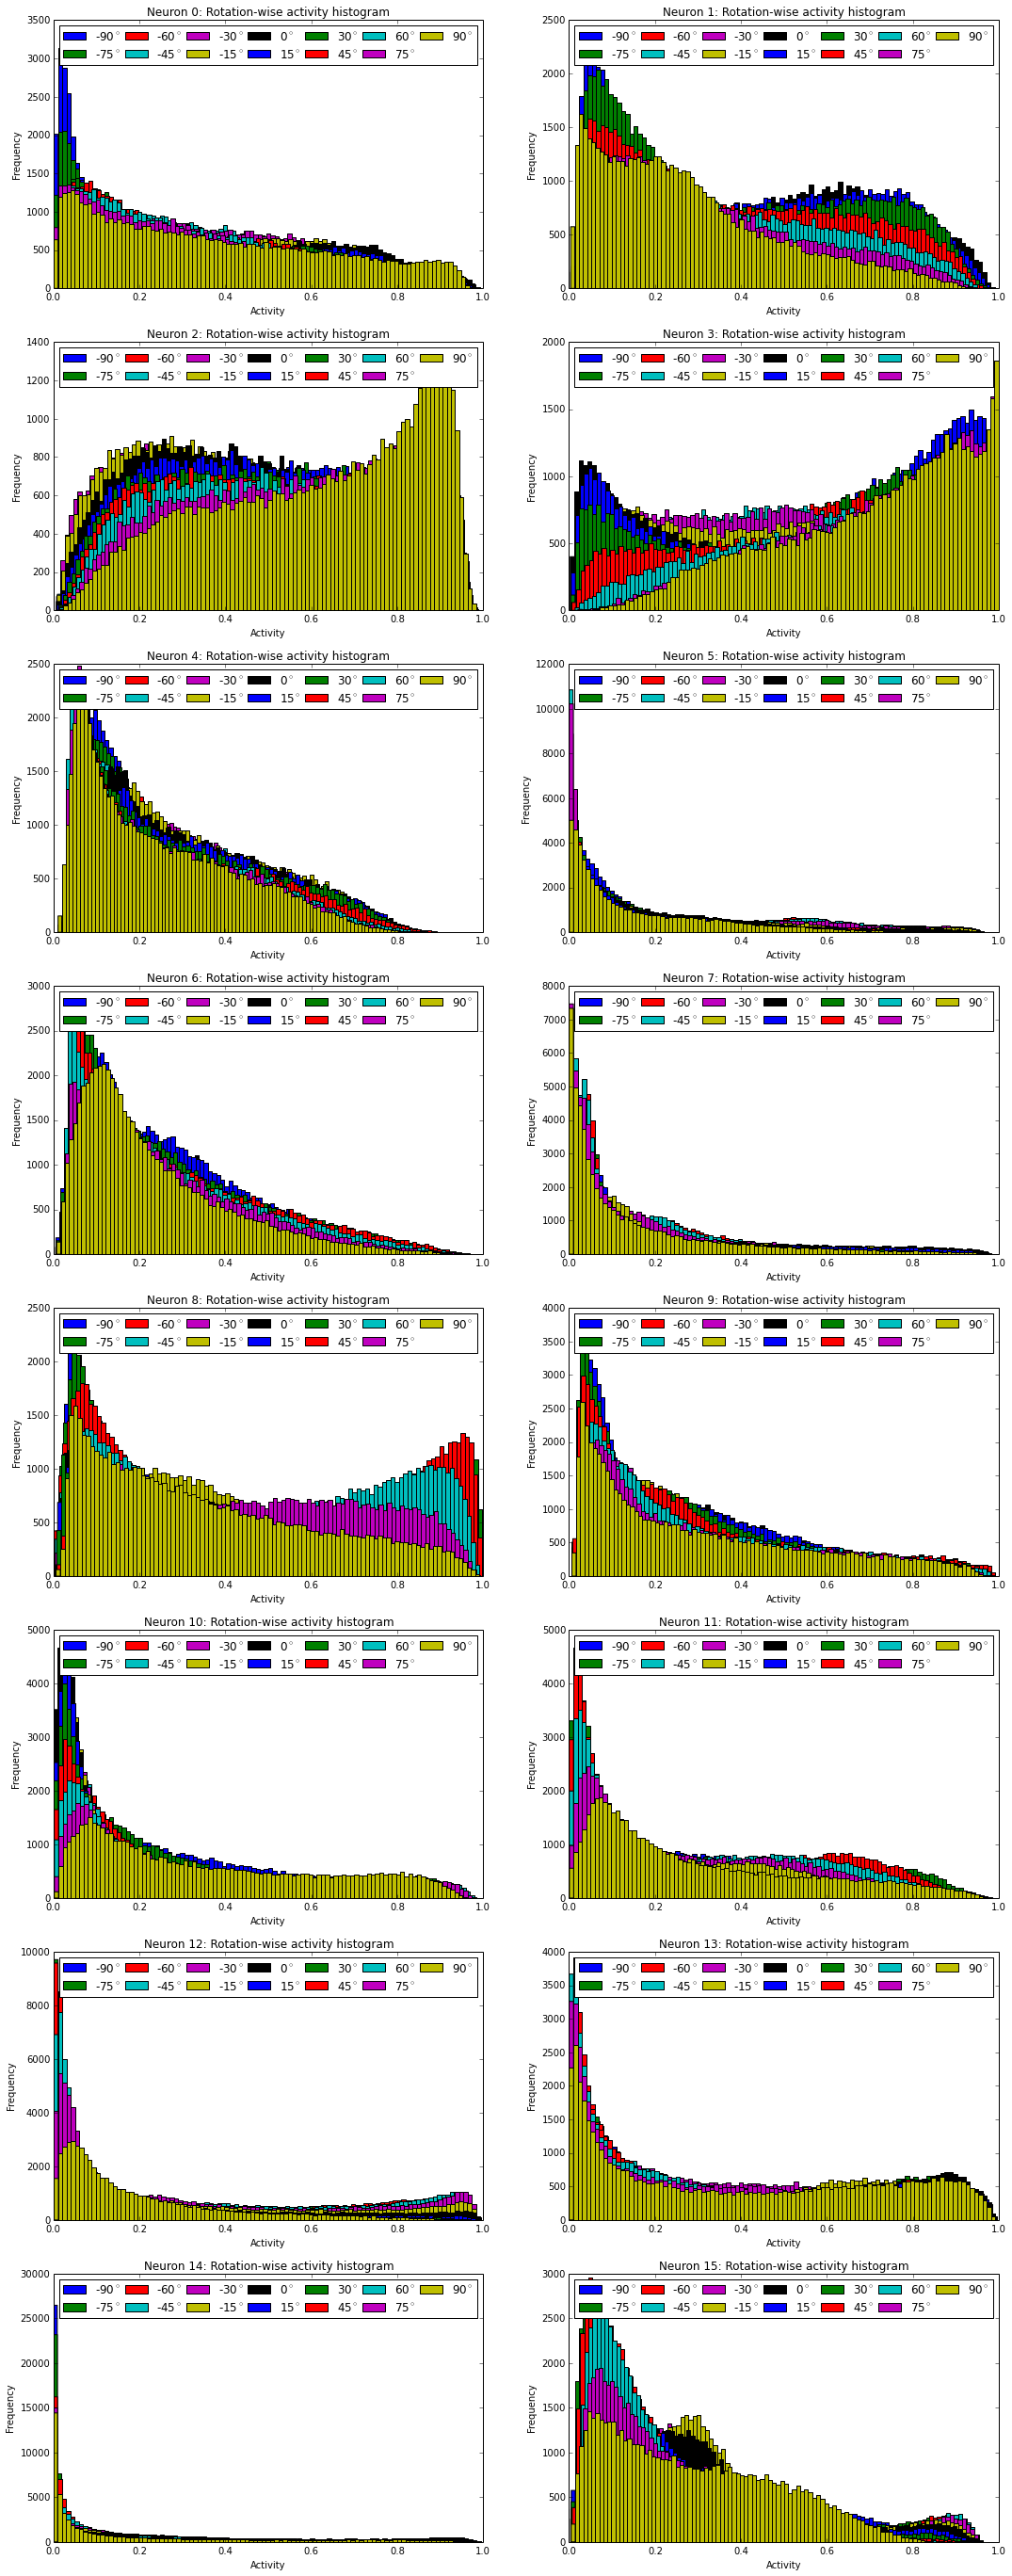

encode4neuron


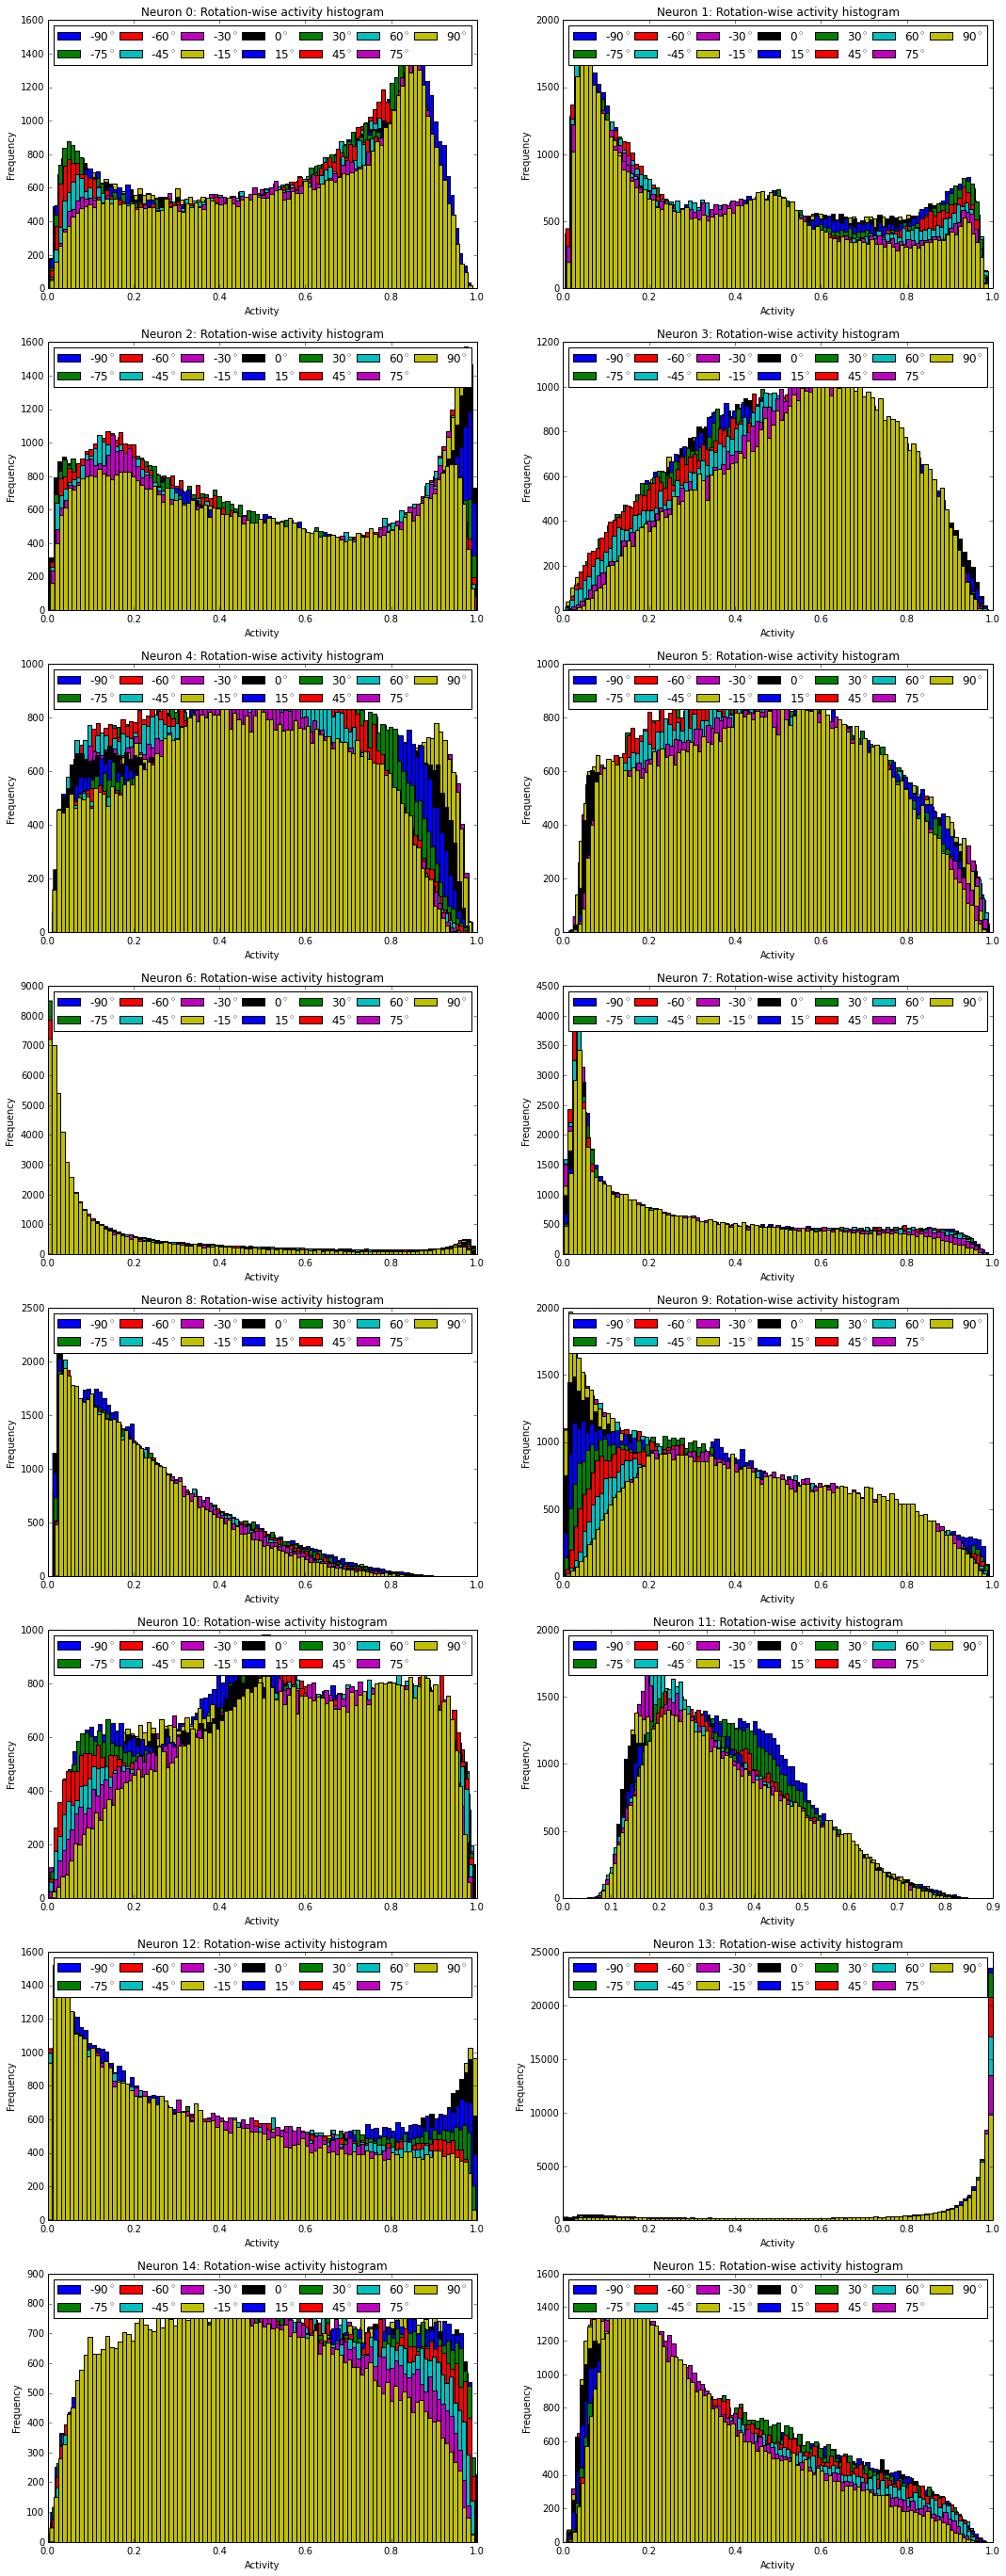

In [16]:
#ROTATION ANGLES
rot_lmdb_path =  '/mnt/raid/dnn/data_oliver/lmdb/MNIST_TRAIN_60000_rot_ang_lmdb/shuffled/'

lmdb_env = lmdb.open(rot_lmdb_path)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
R = []
im_count = 0
for key, value in lmdb_cursor:
        R.append(value)
Rot = np.asarray([float(r) for r in R])


for layer in ['encode1neuron','encode2neuron','encode3neuron','encode4neuron' ]:
    print(layer)
    for neuron_nr, v in enumerate(CL[layer].T):

        if neuron_nr%16 ==0:
            plt.figure(figsize= (18, 8*6))

        plt.subplot(8,2,neuron_nr + 1)
        #plt.subplot(4,28*7,neuron_nr + 1)
        #v = v
        #inds = np.argsort(v)
        #act_ord = v[inds]
        #rot_ord = Rot[inds]
        #plt.scatter(range(len(act_ord)),act_ord, c = rot_ord, marker = 'x', s=100)
        #plt.scatter(Rot[:1000],v, c = Rot[:1000], marker = 'x', s=100)

        l=[]
        angs = np.sort(list(set(Rot)))
        for ang in angs:
            plt.hist(v[Rot==ang], bins = 100)
            l.append('{:0.0f}$^\circ$'.format(ang))
        plt.legend(l, mode="expand", ncol=7)
        plt.title('Neuron {}: Rotation-wise activity histogram'.format(neuron_nr) )
        plt.xlabel('Activity')
        plt.ylabel('Frequency')
        if (neuron_nr+1)%16 == 0:
            plt.show()
            break

    
    



## Kullback-Leibler $KL(P(act./rot)  | | P(act))$

In [3]:
date = '2408'
snap = '390000'
dst_fpath= '/mnt/antares_raid/home/oliver/Experiments/{}/R/activations/activity.hdf5'.format(date)
keys = ['encode1neuron', 'encode2neuron', 'encode3neuron', 'encode4neuron']

dst_fpath= '/mnt/antares_raid/home/oliver/Experiments/{}/R/activations/activity.hdf5'.format(date)

S = ReportInterface()
#S.__save_dict_to_hdf5__(C, dst_fpath)

CL = S.__load_dict_from_hdf5__(dst_fpath)


In [4]:
#ROTATION ANGLES
rot_lmdb_path =  '/mnt/raid/dnn/data_oliver/lmdb/MNIST_TRAIN_60000_rot_ang_lmdb/shuffled/'

lmdb_env = lmdb.open(rot_lmdb_path)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
R = []
im_count = 0
for key, value in lmdb_cursor:
        R.append(value)
Rot = np.asarray([float(r) for r in R])

In [6]:
angs = np.sort(list(set(Rot)))

print(angs)


[-90. -75. -60. -45. -30. -15.   0.  15.  30.  45.  60.  75.  90.]


In [7]:
import scipy
layer = 'encode1neuron'
KL = [[] for n,_ in enumerate(CL[layer].T)]

for neuron_nr, v in enumerate(CL[layer].T):
    for r in angs:
        p, _ = np.histogram(v[Rot==r],bins = 100, density = True) # p = P(act/rot)
        q, _ = np.histogram(v[Rot!=r],bins = 100, density = True) # q = P(act)
        KL[neuron_nr].append(scipy.stats.entropy(p,q))
        

/usr/lib/python2.7/dist-packages/scipy/stats/distributions.py:6024: RuntimeWarning: invalid value encountered in true_divide
  vec = -special.xlogy(pk, pk / qk)


(784, 13)


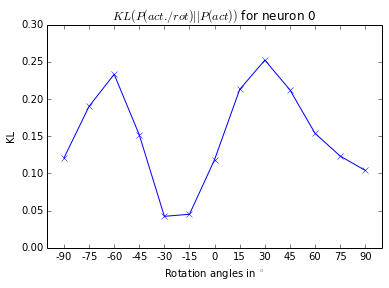

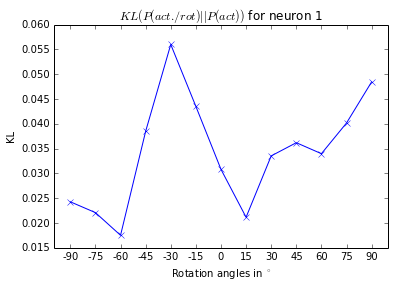

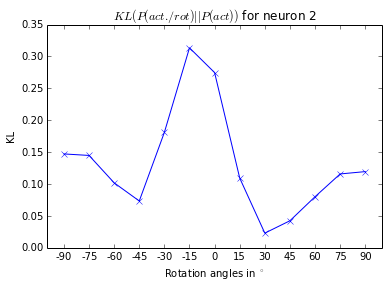

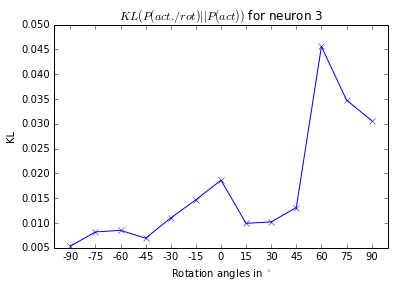

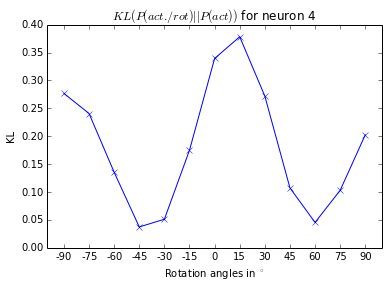

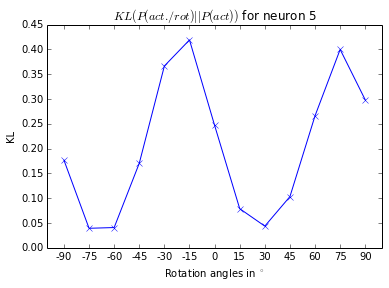

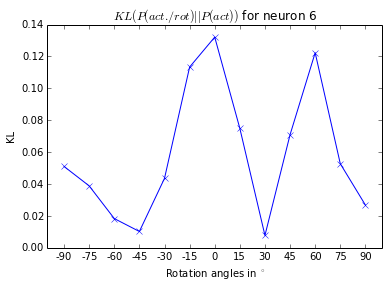

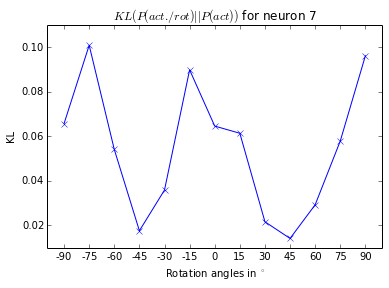

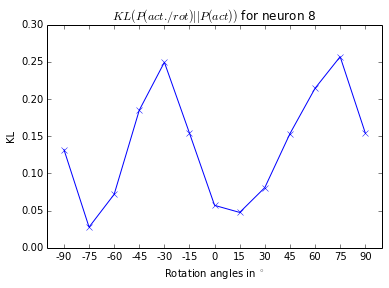

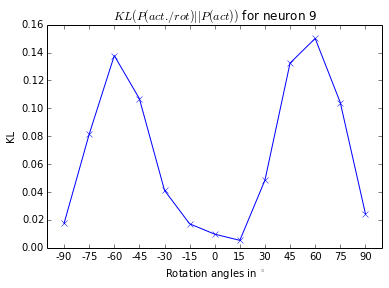

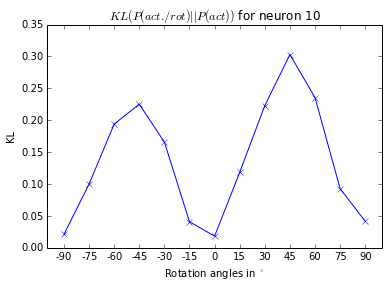

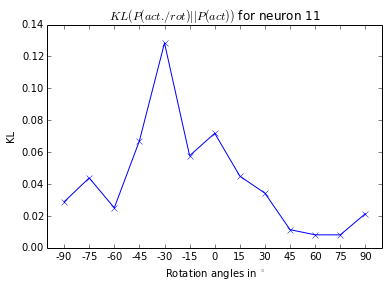

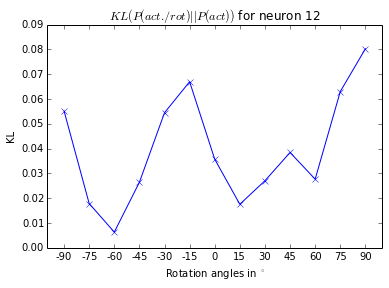

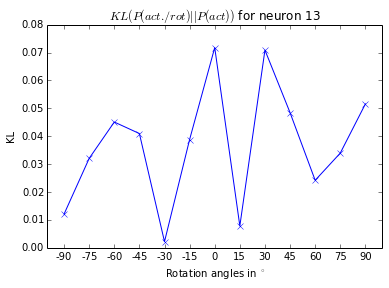

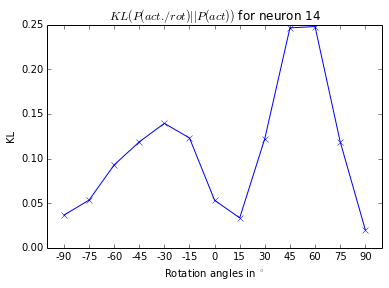

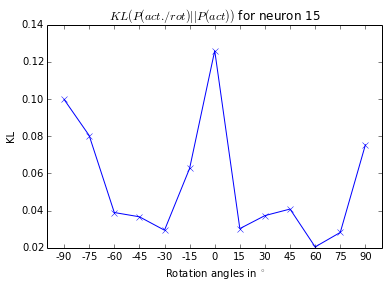

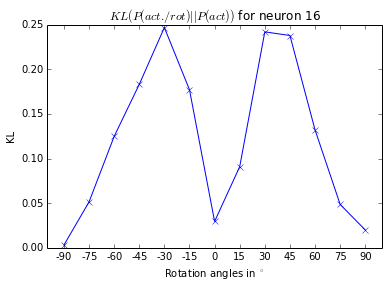

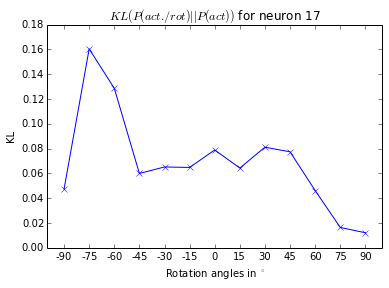

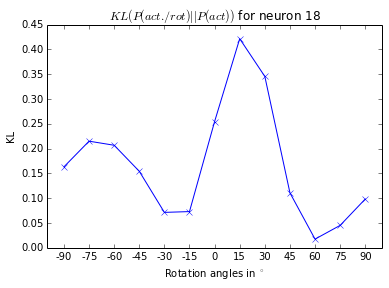

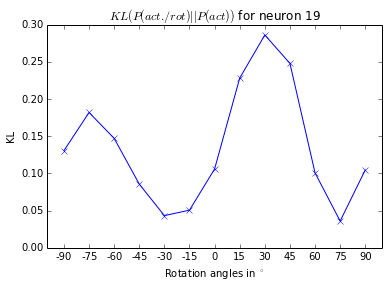

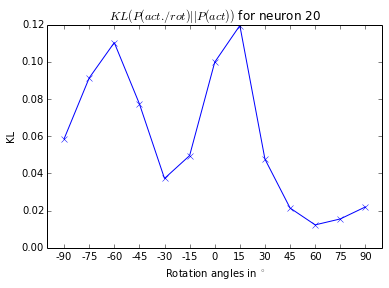

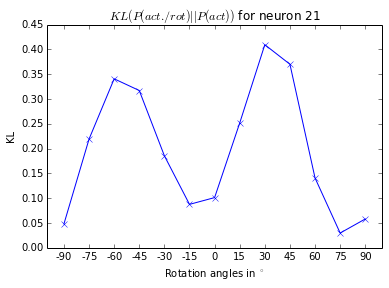

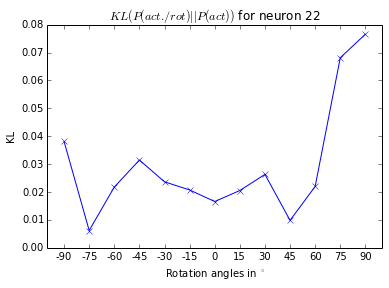

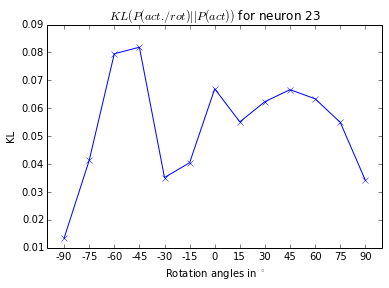

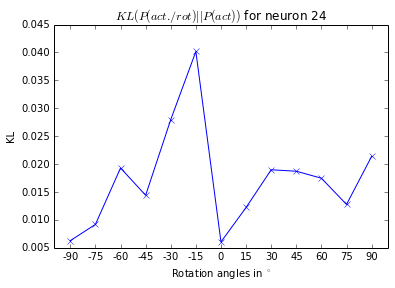

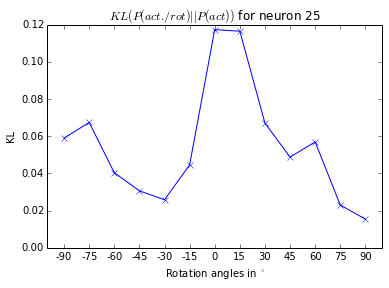

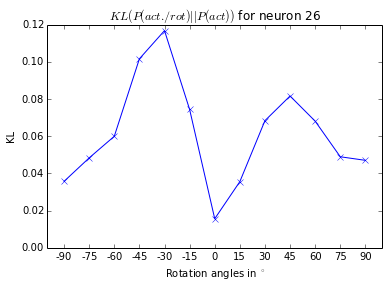

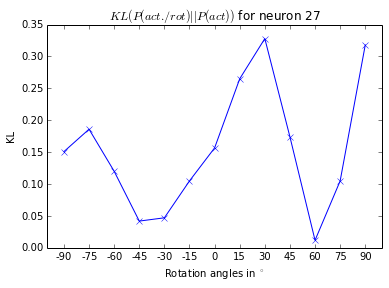

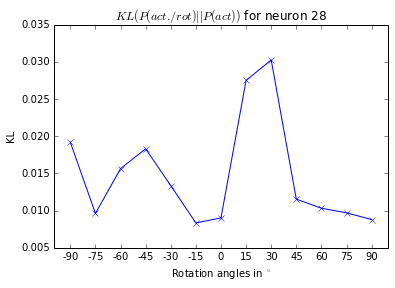

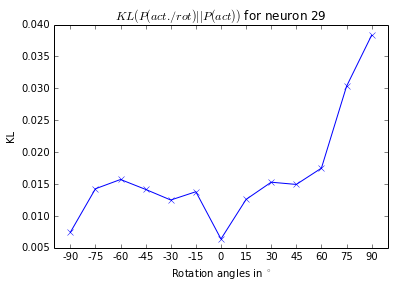

In [8]:
print(np.shape(KL))

for neuron_nr in range(30):
    plt.plot(angs,KL[neuron_nr], marker = 'x')
    plt.xticks(angs, ['{:0.0f}'.format(a) for a in angs])
    plt.title('$KL(P(act./rot)  | | P(act))$ for neuron {}'.format(neuron_nr) )
    plt.xlabel('Rotation angles in $^{\circ}$')
    plt.ylabel('KL')
    plt.show()

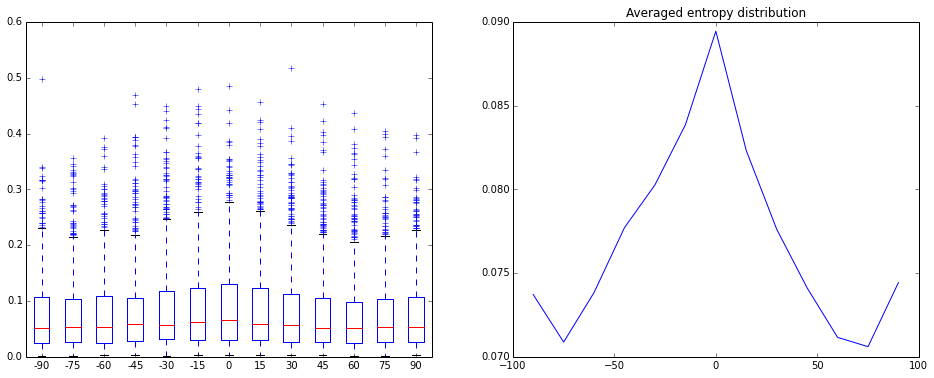

In [34]:
KL_clean = []
for k in KL:
    if np.isinf(k).any() or np.isnan(k).any():
        pass
    else:
        KL_clean.append(k/np.sum(k))

#KL_clean = [np.asarray(k)[~np.isnan(np.asarray(k)) & ~np.isinf(np.asarray(k)) ] for k in KL]
KL_clean = np.asarray(KL_clean)

fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(121)
ax.boxplot(list(np.array(KL).T))
plt.xticks(range(1,len(angs)+1), ['{:0.0f}'.format(a) for a in angs])

ax = fig.add_subplot(122)
#print(KL_clean)
KL_mean = np.mean(KL_clean, axis = 0)
plt.plot(angs, KL_mean)
plt.title('Averaged entropy distribution')
plt.show()

## $KL(p_{act.} //p_{mean})$

In [45]:
n_score = []
for p in KL_clean:
    n_score.append(scipy.stats.entropy(p,KL_mean))
    

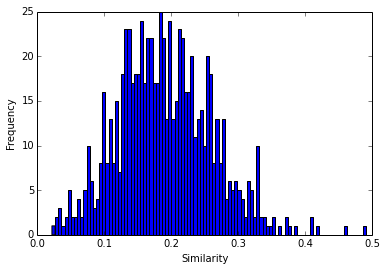

In [46]:
plt.hist(n_score, bins = 100)
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.show()